# 🧠 IndraQuantum Training Monitor (Rank 64)

**Generated:** 2025-12-07 06:49

This notebook visualizes the training dynamics of the Quantum-Inspired Student Model.
**Goal:** Achieve stable convergence with <1M parameters using Knowledge Distillation.


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.optimize import curve_fit

# Configuration
log_file = "../logs/training_metrics_rank64_optimized.csv"
if not os.path.exists(log_file):
    print("Log file not found! Ensure training is running.")
else:
    df = pd.read_csv(log_file)
    # Fix column names if needed
    if "KD_Logits" in df.columns:
        df["KD_Loss"] = df["KD_Logits"]

    print(f"Loaded {len(df)} batch records")
    print(f"Current Epoch: {df['Epoch'].max()}")
    df.tail()

Loaded 13926 batch records
Current Epoch: 50


## 1. Epoch Oscillation Analysis

This plot visualizes the **Stability** of learning.

- **Line**: Average CE Loss (Accuracy)
- **Shaded Area**: Standard Deviation (Batch-to-Batch Noise)


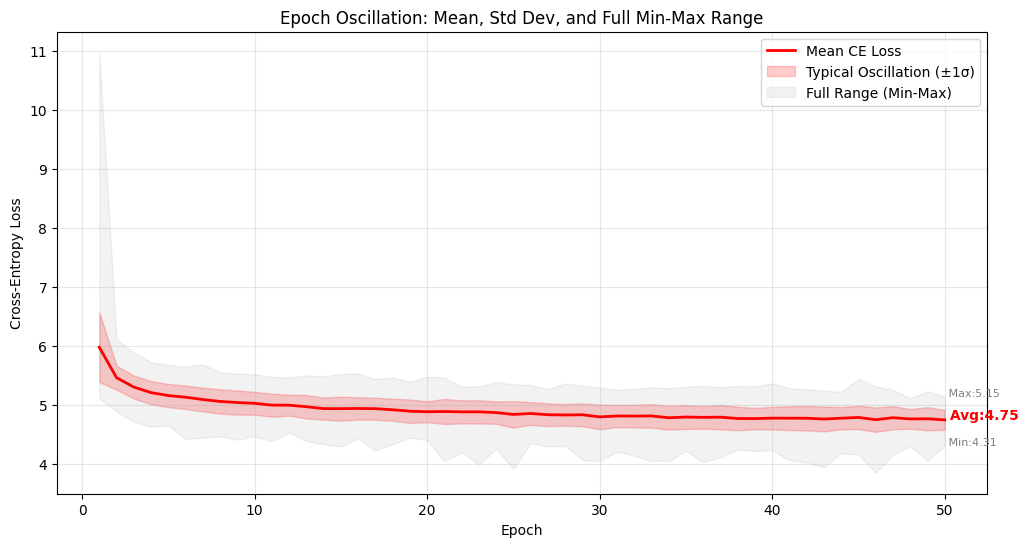

In [23]:
plt.figure(figsize=(12, 6))
# Calculate detailed stats
epoch_stats = df.groupby("Epoch")["CE_Loss"].agg(["mean", "std", "min", "max"])

# 1. Main Trend (Mean)
plt.plot(
    epoch_stats.index,
    epoch_stats["mean"],
    label="Mean CE Loss",
    color="red",
    linewidth=2,
)

# 2. Typical Oscillation (Standard Deviation)
plt.fill_between(
    epoch_stats.index,
    epoch_stats["mean"] - epoch_stats["std"],
    epoch_stats["mean"] + epoch_stats["std"],
    color="red",
    alpha=0.2,
    label="Typical Oscillation (±1σ)",
)

# 3. Extreme Oscillation (Min-Max Range)
plt.fill_between(
    epoch_stats.index,
    epoch_stats["min"],
    epoch_stats["max"],
    color="gray",
    alpha=0.1,
    label="Full Range (Min-Max)",
)

# Annotate current values
last_ep = epoch_stats.index[-1]
last_mean = epoch_stats["mean"].iloc[-1]
last_min = epoch_stats["min"].iloc[-1]
last_max = epoch_stats["max"].iloc[-1]

plt.text(last_ep, last_mean, f" Avg:{last_mean:.2f}", color="red", fontweight="bold")
plt.text(last_ep, last_max, f" Max:{last_max:.2f}", color="gray", fontsize=8)
plt.text(last_ep, last_min, f" Min:{last_min:.2f}", color="gray", fontsize=8)

plt.title("Epoch Oscillation: Mean, Std Dev, and Full Min-Max Range")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## 2. Advanced Multi-Metric Analysis

- **Perplexity ($e^{CE}$)**: The "Surprise Factor". Lower is better.
- **Relative Rate**: Improvements relative to start.
- **3D Trajectory**: (Epoch, CE, KD) optimization path.
- **Velocity**: Rate of change per epoch.


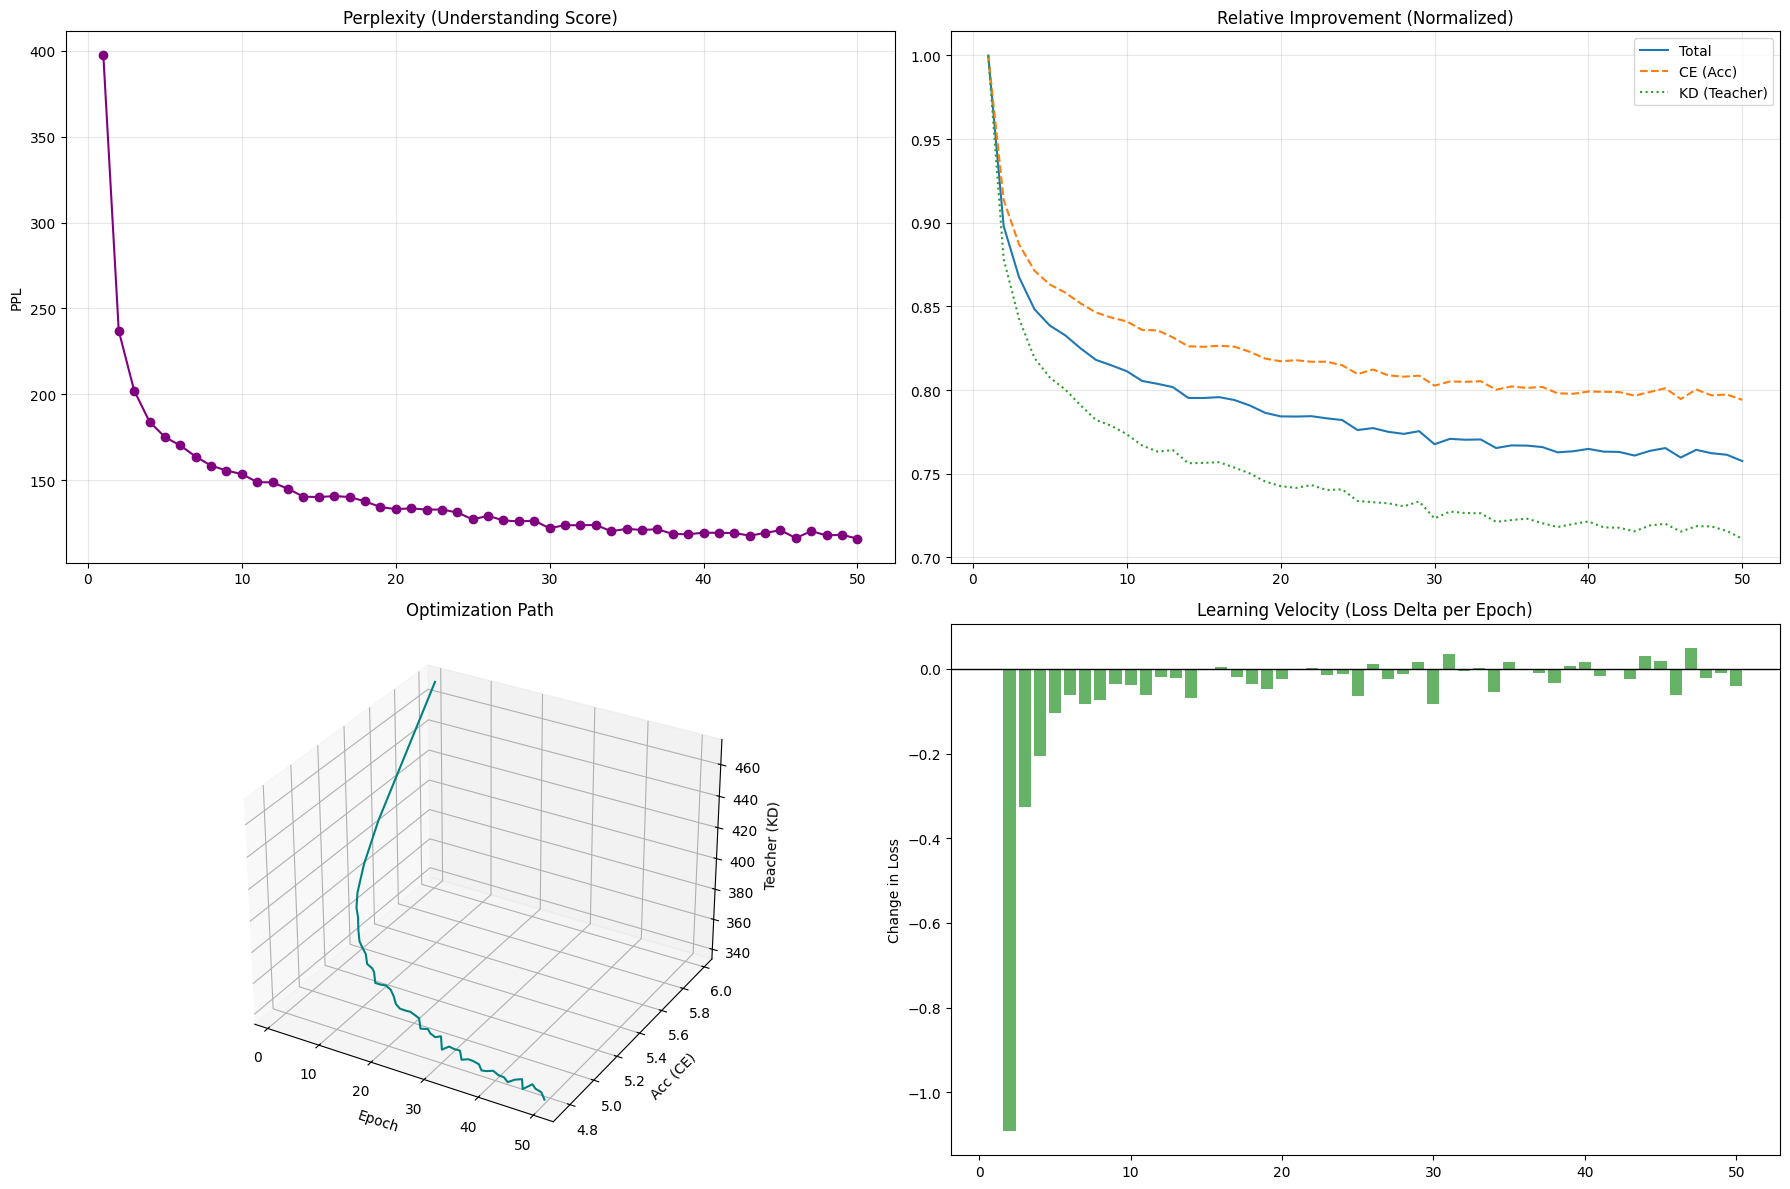

In [24]:
fig = plt.figure(figsize=(18, 12))
epoch_mean = df.groupby("Epoch").mean()

# A. Perplexity
ax1 = fig.add_subplot(2, 2, 1)
ppl = np.exp(epoch_mean["CE_Loss"])
ax1.plot(ppl.index, ppl, color="purple", marker="o")
ax1.set_title("Perplexity (Understanding Score)")
ax1.set_ylabel("PPL")
ax1.grid(True, alpha=0.3)

# B. Relative Improvement
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(
    epoch_mean.index,
    epoch_mean["Total_Loss"] / epoch_mean["Total_Loss"].iloc[0],
    label="Total",
)
ax2.plot(
    epoch_mean.index,
    epoch_mean["CE_Loss"] / epoch_mean["CE_Loss"].iloc[0],
    label="CE (Acc)",
    linestyle="--",
)
ax2.plot(
    epoch_mean.index,
    epoch_mean["KD_Loss"] / epoch_mean["KD_Loss"].iloc[0],
    label="KD (Teacher)",
    linestyle=":",
)
ax2.set_title("Relative Improvement (Normalized)")
ax2.legend()
ax2.grid(True, alpha=0.3)

# C. 3D Trajectory
ax3 = fig.add_subplot(2, 2, 3, projection="3d")
ax3.plot(epoch_mean.index, epoch_mean["CE_Loss"], epoch_mean["KD_Loss"], color="teal")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Acc (CE)")
ax3.set_zlabel("Teacher (KD)")
ax3.set_title("Optimization Path")

# D. Learning Rate Efficiency
ax4 = fig.add_subplot(2, 2, 4)
loss_diff = epoch_mean["Total_Loss"].diff().fillna(0)
ax4.bar(loss_diff.index, loss_diff, color="green", alpha=0.6)
ax4.set_title("Learning Velocity (Loss Delta per Epoch)")
ax4.set_ylabel("Change in Loss")
ax4.axhline(0, color="black", linewidth=1)

plt.tight_layout()
plt.show()

## 3. Convergence Projection

- **Target CE (Safe Goal)**: 4.0 (Typical for <1M params)
- **Target CE (Stretch Goal)**: 3.5 (Fluent English)

We estimate the **Expected Completion Epoch** based on the current learning speed (last 5 epochs).


Current CE: 4.7531
Target CE: 4.0
Distance to Target: 0.7531
Current Velocity: -0.0020 loss/epoch
ESTIMATED COMPLETION: Epoch 436


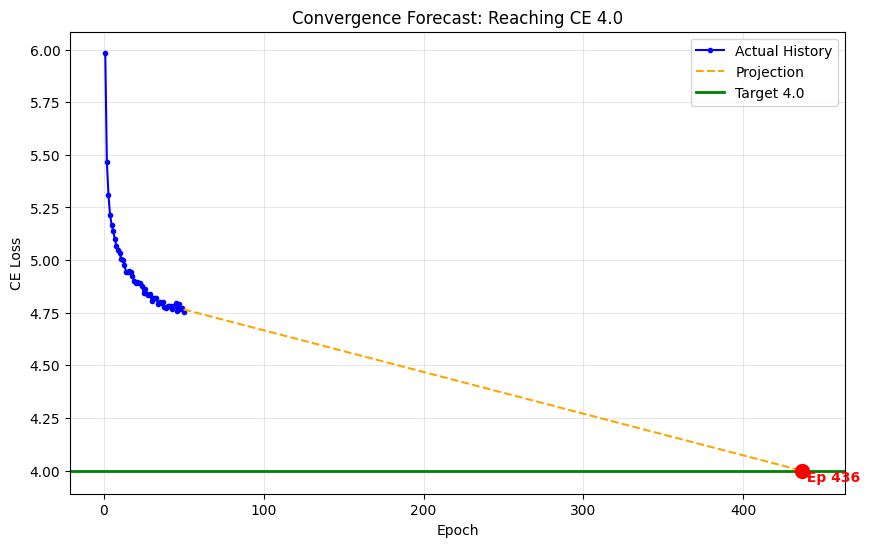

In [25]:
TARGET_CE = 4.0
recent_window = 10  # Use trend of last 10 epochs

ce_history = df.groupby("Epoch")["CE_Loss"].mean()

if len(ce_history) > recent_window:
    # Linear fit prediction
    y_recent = ce_history.iloc[-recent_window:]
    x_recent = y_recent.index

    coef = np.polyfit(x_recent, y_recent, 1)
    slope = coef[0]
    intercept = coef[1]

    current_ce = ce_history.iloc[-1]
    dist_to_target = current_ce - TARGET_CE

    print(f"Current CE: {current_ce:.4f}")
    print(f"Target CE: {TARGET_CE}")
    print(f"Distance to Target: {dist_to_target:.4f}")
    print(f"Current Velocity: {slope:.4f} loss/epoch")

    if slope < 0 and dist_to_target > 0:
        target_epoch = (TARGET_CE - intercept) / slope
        print(f"ESTIMATED COMPLETION: Epoch {int(target_epoch)}")

        plt.figure(figsize=(10, 6))
        plt.plot(
            ce_history.index,
            ce_history,
            label="Actual History",
            marker=".",
            color="blue",
        )

        fut_x = np.linspace(ce_history.index[-1], target_epoch + 5, 20)
        fut_y = slope * fut_x + intercept
        plt.plot(fut_x, fut_y, label="Projection", linestyle="--", color="orange")

        plt.axhline(TARGET_CE, color="green", label="Target 4.0", linewidth=2)
        plt.scatter([target_epoch], [TARGET_CE], color="red", s=100, zorder=5)
        plt.text(
            target_epoch,
            TARGET_CE - 0.05,
            f" Ep {int(target_epoch)}",
            color="red",
            fontweight="bold",
        )

        plt.title(f"Convergence Forecast: Reaching CE {TARGET_CE}")
        plt.xlabel("Epoch")
        plt.ylabel("CE Loss")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print("Model is not converging linearly or already passed target.")
else:
    print("Need more data for projection.")